In [49]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from config import settings
from data import SQLRepository
from IPython.display import VimeoVideo
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [50]:
connection=sqlite3.connect(settings.db_name,check_same_thread=False)
repo=SQLRepository(connection=connection)
print("repo type:",type(repo))
print("repo.connection type:",type(repo.connection))

repo type: <class 'data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


In [51]:
#read apple data from database
df_aapl=repo.read_table(table_name="AAPL",limit=2500)
print("df_aapl type:",type(df_aapl))
print("df_aapl shape",df_aapl.shape)
df_aapl.head()

df_aapl type: <class 'pandas.core.frame.DataFrame'>
df_aapl shape (2500, 5)


,open,high,low,close,volume
date,,,,,
2025-11-03,270.420,270.85,266.25,269.05,50194583.0
2025-10-31,276.990,277.32,269.16,270.37,86167123.0
2025-10-30,271.990,274.14,268.48,271.40,69886534.0
2025-10-29,269.275,271.41,267.11,269.70,51086742.0
2025-10-28,268.985,269.89,268.15,269.00,41534759.0


In [52]:
def wrangle_data(ticker,n_observations):
    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df=repo.read_table(table_name= ticker,limit=n_observations+1)


    # Sort DataFrame ascending by date
    df.sort_index(ascending=True,inplace=True)

    # Create "return" column
    df["return"]=df["close"].pct_change()*100

    # Return returns
    return df["return"].dropna()

In [53]:
y_aapl = wrangle_data(ticker="AAPL", n_observations=2500)

# Is `y_ambuja` a Series?
assert isinstance(y_aapl, pd.Series)

# Are there 2500 observations in the Series?
assert len(y_aapl) == 2500

# Is `y_ambuja` name "return"?
assert y_aapl.name == "return"

# Does `y_ambuja` have a DatetimeIndex?
assert isinstance(y_aapl.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_aapl.index == y_aapl.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_aapl.isnull().sum() == 0

y_aapl.head()

date
2015-11-24    0.959660
2015-11-25   -0.715007
2015-11-27   -0.186393
2015-11-30    0.415924
2015-12-01   -0.811496
Name: return, dtype: float64

In [54]:
#ouput returns of TESLA stock
y_tsla = wrangle_data(ticker="TSLA",n_observations=2500)

print("y_tsla type:", type(y_tsla))
print("y_tsla shape:", y_tsla.shape)
y_tsla.head()

y_tsla type: <class 'pandas.core.series.Series'>
y_tsla shape: (2500,)


date
2015-11-24    0.229621
2015-11-25    5.218786
2015-11-27    0.857864
2015-11-30   -0.582876
2015-12-01    3.009641
Name: return, dtype: float64

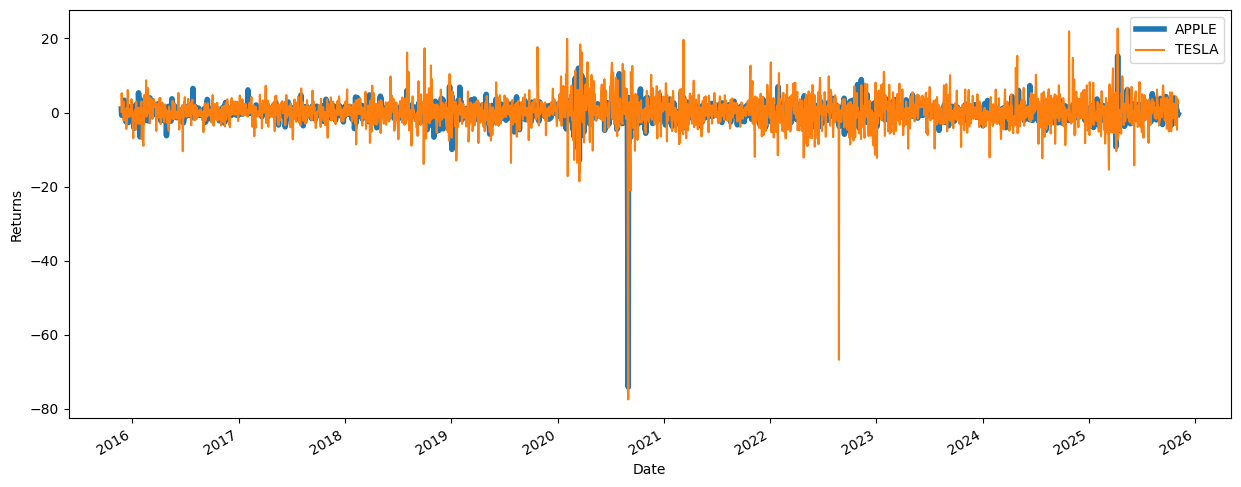

In [55]:
# comparing returns of TESLA and APPLE
fig, ax=plt.subplots(figsize=(15,6))
y_aapl.plot(ax=ax,label="APPLE",linewidth=4)
y_tsla.plot(ax=ax,label="TESLA",color="C1")
#axes
plt.xlabel("Date")
plt.ylabel("Returns")
#Add legend
plt.legend();

Text(0.5, 1.0, 'Distribution of Apple Daily Returns')

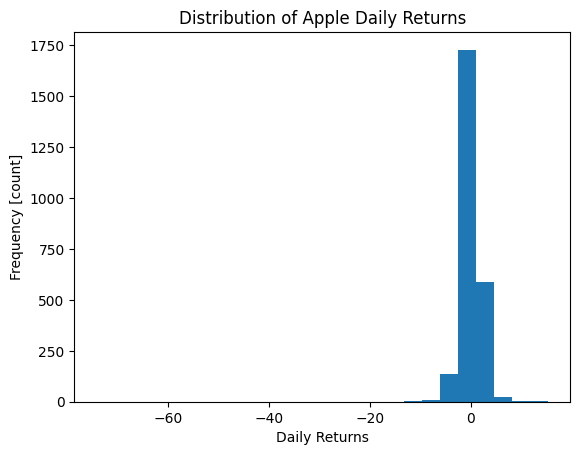

In [56]:
# Create histogram of `y_aapl`, 25 bins

plt.hist(y_aapl,bins=25)
# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of Apple Daily Returns")

In [57]:
#calculating volatility(daily)
aapl_daily_volatility=y_aapl.std()
tsla_daily_volatility=y_tsla.std()
print("aapl_daily_volatility:",aapl_daily_volatility)
print("tsla_daily_volatility:",tsla_daily_volatility)

aapl_daily_volatility: 2.3626065087139483
tsla_daily_volatility: 4.255033112852935


In [58]:
#calculating annual volatility
aapl_annual_volatility=aapl_daily_volatility*np.sqrt(252)
tsla_annual_volatility=tsla_daily_volatility*np.sqrt(252)
print("aapl_annual_volatility:",aapl_annual_volatility)
print("tsla_annual_volatility:",tsla_annual_volatility)


aapl_annual_volatility: 37.50521560775798
tsla_annual_volatility: 67.5465566217234


In [59]:
aapl_rolling_50d_volatility=y_aapl.rolling(window=50).std().dropna()
print("rolling_50d_volatility type:", type(aapl_rolling_50d_volatility))
print("rolling_50d_volatility shape:", aapl_rolling_50d_volatility.shape)
aapl_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (2451,)


date
2016-02-05    2.029898
2016-02-08    2.031242
2016-02-09    2.031605
2016-02-10    2.031911
2016-02-11    2.028420
Name: return, dtype: float64

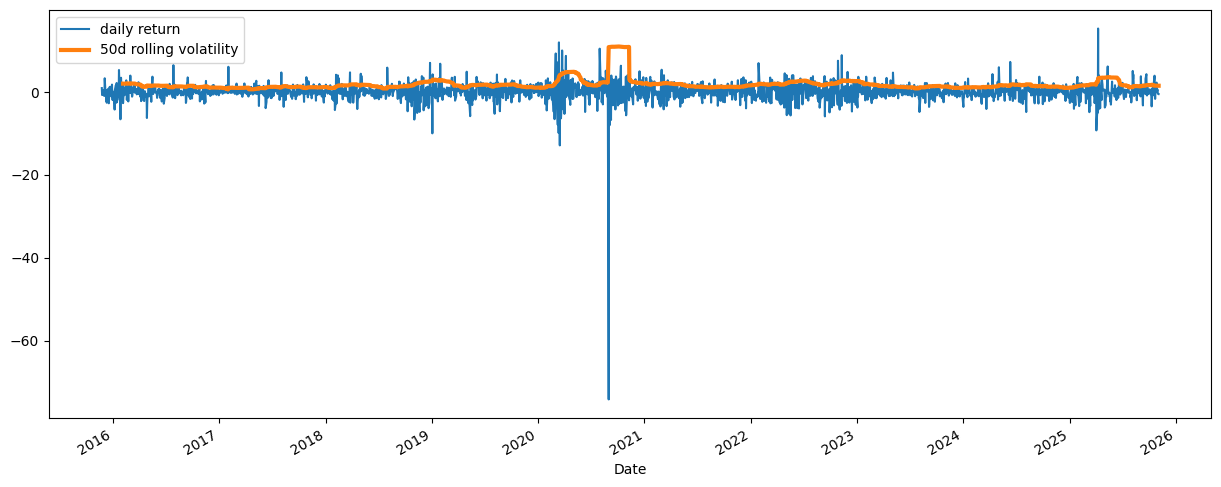

In [60]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y_aapl.plot(ax=ax,label="daily return")

# Plot `ambuja_rolling_50d_volatility`
aapl_rolling_50d_volatility.plot(ax=ax,label="50d rolling volatility",linewidth=3)

# Add x-axis label
plt.xlabel("Date")
#save png
plt.savefig('daily returns on rolling window 50days', dpi=300, bbox_inches='tight')

# Add legend
plt.legend();

Text(0, 0.5, 'Squared Returns')

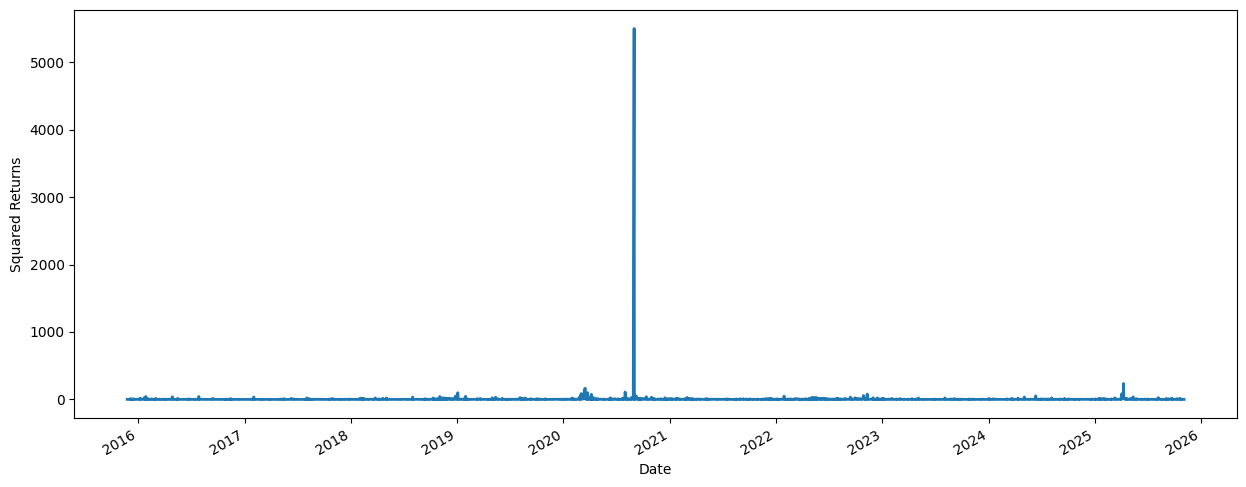

In [61]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_aapl**2).plot(ax=ax,linewidth=2)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns")

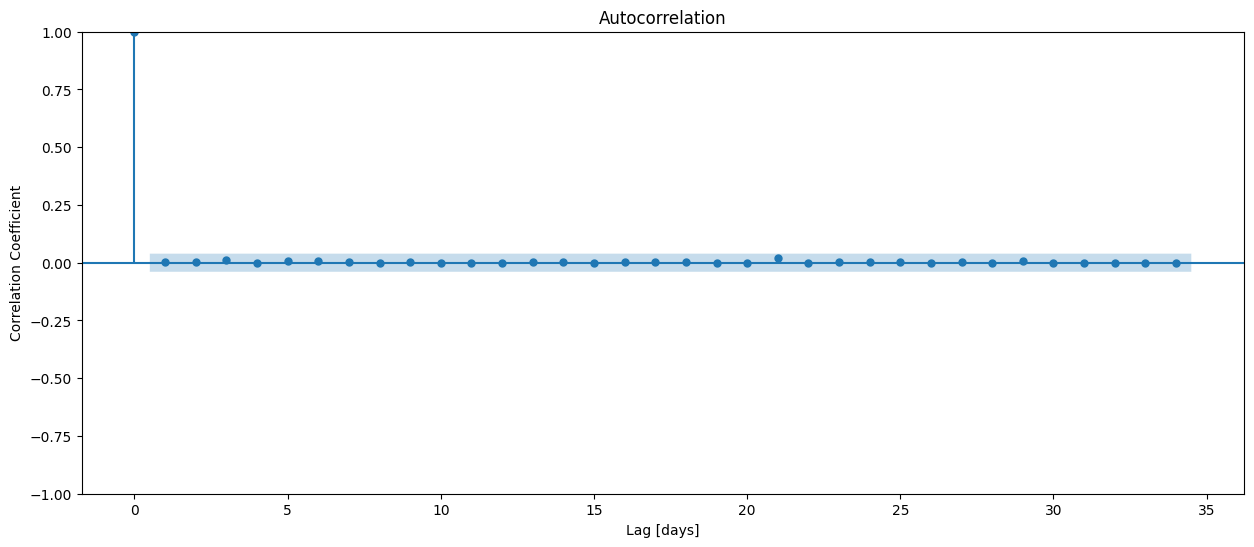

In [62]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_aapl**2,ax=ax)


# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

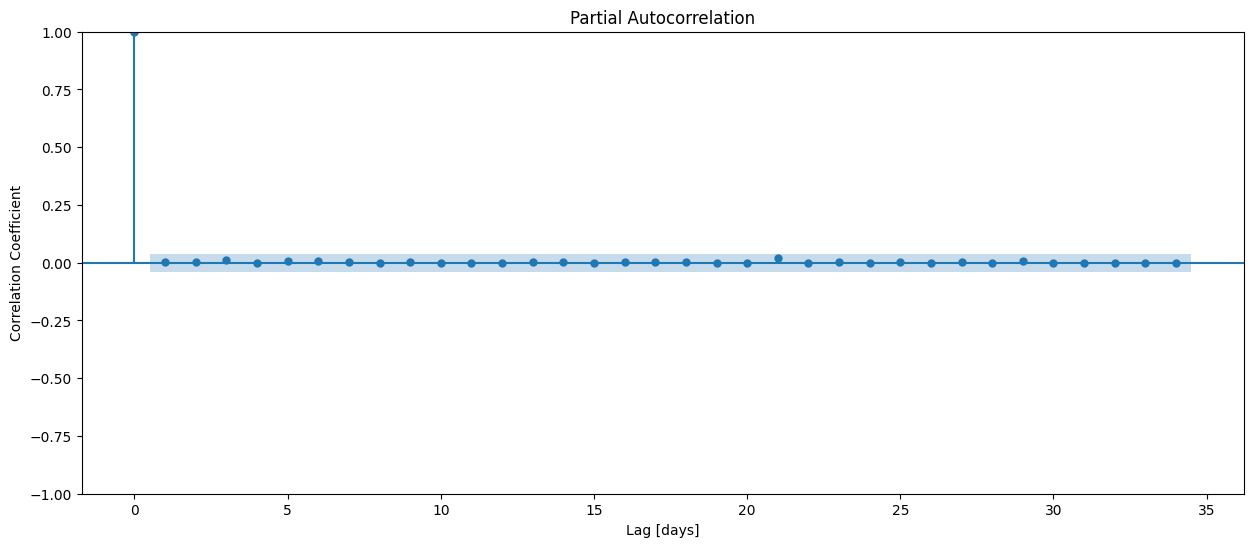

In [63]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_aapl**2,ax=ax)


# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In [64]:
cutoff_test = int(len(y_aapl)*0.8)
y_aapl_train = y_aapl.iloc[:cutoff_test]
print("y_aapl_train type:", type(y_aapl_train))
print("y_aapl_train shape:", y_aapl_train.shape)
y_aapl_train.head()

y_aapl_train type: <class 'pandas.core.series.Series'>
y_aapl_train shape: (2000,)


date
2015-11-24    0.959660
2015-11-25   -0.715007
2015-11-27   -0.186393
2015-11-30    0.415924
2015-12-01   -0.811496
Name: return, dtype: float64

In [65]:
#Building and training model
model=arch_model(
    y_aapl_train,
    p=1, #alpha terms
    q=1, #beta terms
    rescale=False #how model fits
).fit(disp=0)
print("model type",type(model))
#show model summary
model.summary()

model type <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4359.39
Distribution:                  Normal   AIC:                           8726.78
Method:            Maximum Likelihood   BIC:                           8749.18
                                        No. Observations:                 2000
Date:                Tue, Nov 04 2025   Df Residuals:                     1999
Time:                        15:05:02   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0149  8.110e-02      0.184      0.854 [ -0.144,  0.174]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0599      0.273      0.220      0.826   [ -0.475,  0.594]
alpha[1]       0.0667  1.779e-02      3.747  1.791e-04 [3.179e-02,  0.102]
beta[1]        0.9333      0.102      9.160  5.168e-20   [  0.734,  1.133]
==========================================================================

Covariance estimator: robust
"""

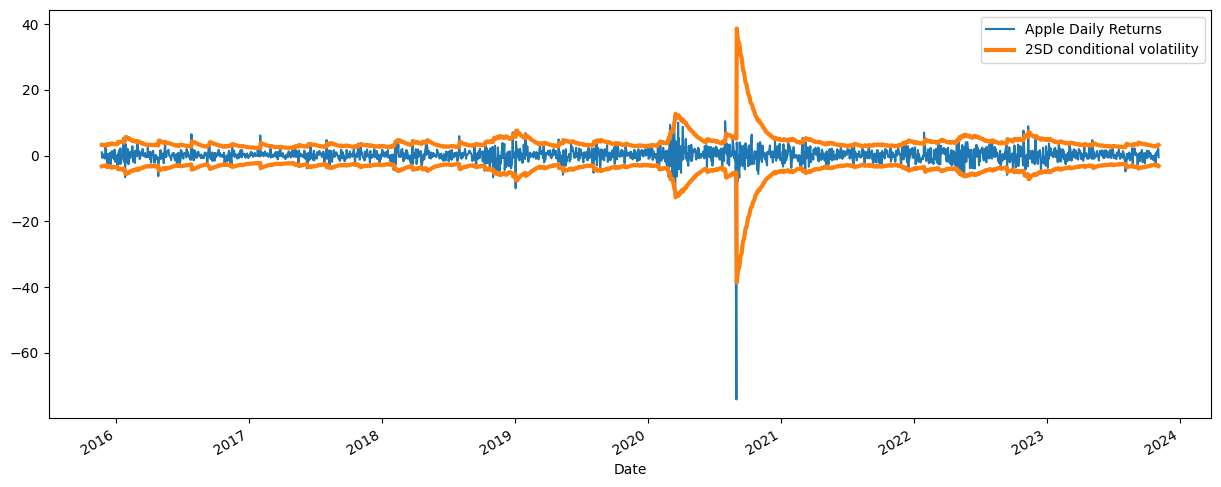

In [66]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_aapl_train.plot(ax=ax,label="Apple Daily Returns")

# Plot conditional volatility * 2(multyplying by 2 raises the line by doing 2 standard deviations)
(2*model.conditional_volatility).plot(ax=ax,color="C1",label="2SD conditional volatility",linewidth=3)

# Plot conditional volatility * -2
(-2*model.conditional_volatility.rename("")).plot(ax=ax,color="C1",linewidth=3)


# Add axis labels
plt.xlabel("Date")
plt.savefig('Apple daily returns vs 2SD conditional volatility.png', dpi=300, bbox_inches='tight')


# Add legend
plt.legend()

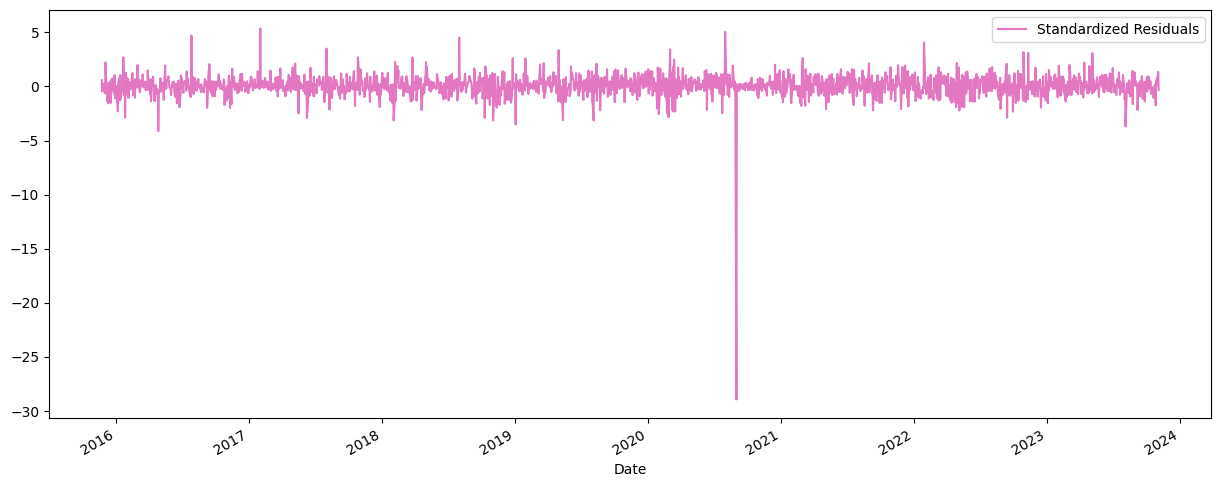

In [67]:
#Plotting the starndadize residuals
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax,label="Standardized Residuals",color="C6")

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend()

Text(0.5, 1.0, 'Distribution of Standardized Residuals')

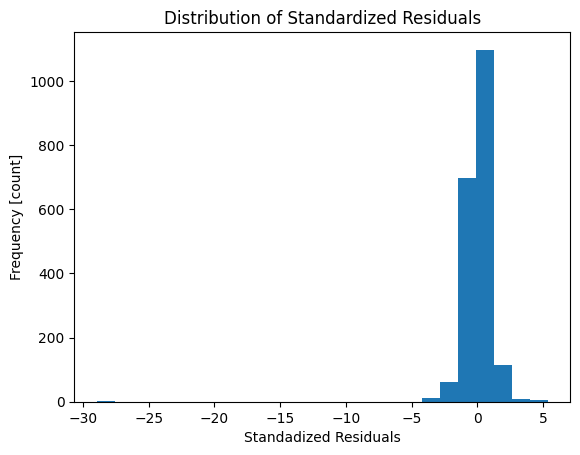

In [68]:
# Create histogram of standardized residuals, 25 bins-residuals divorced of time

plt.hist(model.std_resid,bins=25)
# Add axis labels

plt.xlabel("Standadized Residuals")
plt.ylabel("Frequency [count]")
# Add title
plt.title("Distribution of Standardized Residuals")

Text(0, 0.5, 'correlation coefficient')

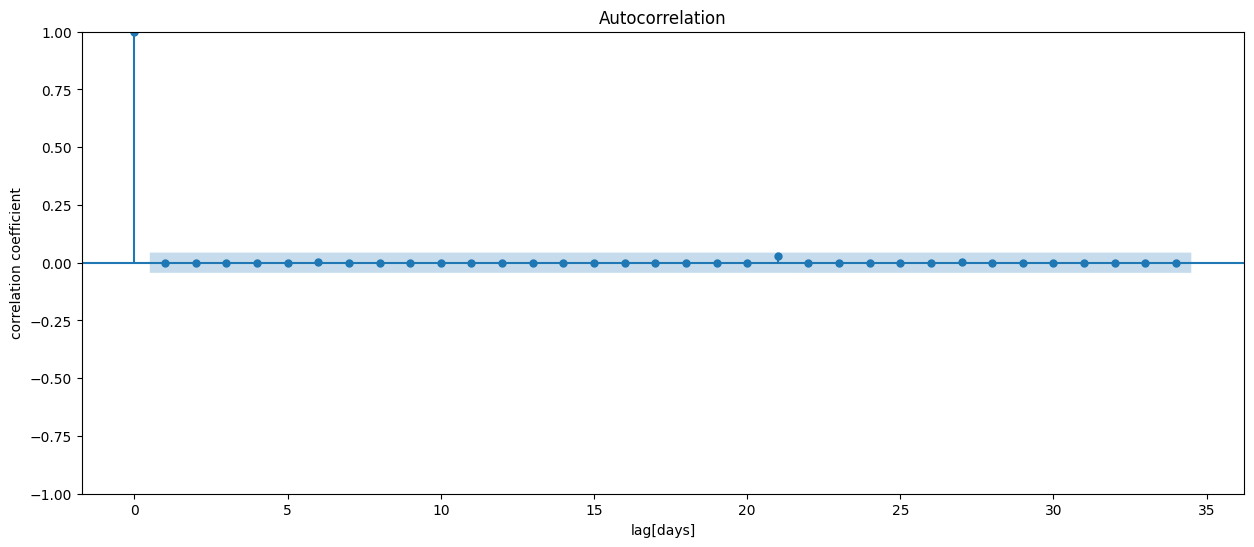

In [69]:
#ACF plot of standardized residuals to check for auto correlation
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2,ax=ax)

# Add axis labels
plt.xlabel("lag[days]")
plt.ylabel("correlation coefficient")

In [70]:
#last day of our training
y_aapl_train.tail()


date
2023-10-30    1.230531
2023-10-31    0.281872
2023-11-01    1.873865
2023-11-02    2.069322
2023-11-03   -0.518106
Name: return, dtype: float64

In [71]:
#EVALUATE
#one day forecast(the prediction output is for the given date plus 1 day a horizon of 1)
#model forecast shows the predicted variance
one_day_forecast=model.forecast(horizon=1,reindex=False).variance
one_day_forecast

,h.1
date,
2023-11-03,2.427447


In [72]:
#accesing the predicted value and finding squareroot to get volatility
one_day_forecast.iloc[0,0]**0.5

np.float64(1.558026636480671)

In [73]:
# using walk forward validation to evaluate our model on test set data
#create empty list to hold predictions
predictions=[]
#calculate size of test data(20%)
test_size=int(len(y_aapl)*0.2)
#walk forward
for i in range (test_size):
    #create test data
    y_train=y_aapl.iloc[:-(test_size- i)]
    #train model
    model=arch_model(y_train,p=1,q=1,rescale=False).fit(disp=0)
    #Generate next predictions (volatility is not variance)
    next_pred=model.forecast(horizon=1,reindex=False).variance.iloc[0,0]**0.5
    #Append predictions to list
    predictions.append(next_pred)
#create series from prediction list
y_test_wfv=pd.Series(predictions,index=y_aapl.tail(test_size).index)
print ("y_test_wfv type:",type(y_test_wfv))
print("y_test_wfv shape:",y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2023-11-06    1.558027
2023-11-07    1.569764
2023-11-08    1.579646
2023-11-09    1.551924
2023-11-10    1.520125
dtype: float64

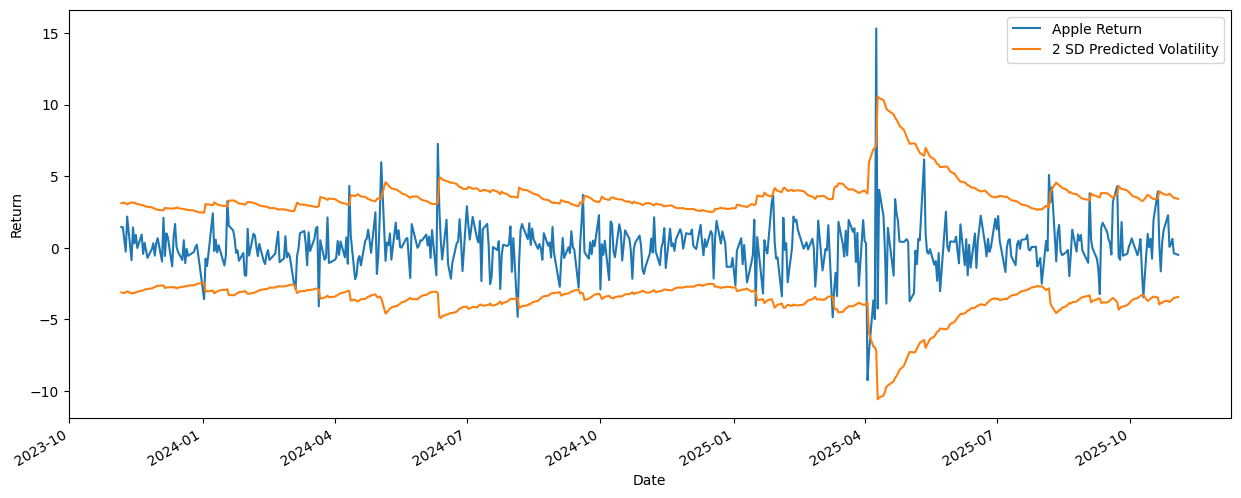

In [74]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_aapl.tail(test_size).plot(ax=ax, label="Apple Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")
#save 
plt.savefig('Apple return vs 2SD predicted volatility (test data plot).png', dpi=300, bbox_inches='tight')

# Add legend
plt.legend();

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

#  y_aapl (full returns Series) and y_test_wfv
# Get test data
test_size = int(len(y_aapl) * 0.2)
y_test = y_aapl.tail(test_size)

# y_test.mean()
mu = y_test.mean()

# Compute raw residuals
raw_resids = y_test - mu

# Standardize using predicted volatilities
std_resids = raw_resids / y_test_wfv

# Create Series for plotting
std_resid_series = pd.Series(std_resids.values, index=y_test.index)

print("std_resid_series type:", type(std_resid_series))
print("std_resid_series shape:", std_resid_series.shape)
print(std_resid_series.head())

print(f"Std of std residuals: {std_resid_series.std():.4f} (should be ~1)")

std_resid_series type: <class 'pandas.core.series.Series'>
std_resid_series shape: (500,)
date
2023-11-06    0.873491
2023-11-07    0.857121
2023-11-08    0.309501
2023-11-09   -0.233288
2023-11-10    1.373431
dtype: float64
Std of std residuals: 0.9109 (should be ~1)


Text(0.5, 0, 'Date')

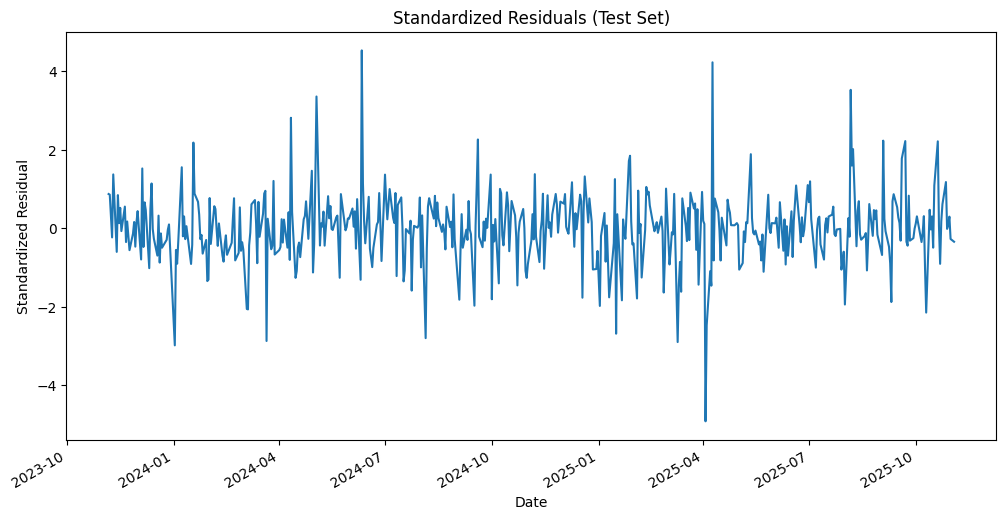

In [76]:
# Time Series of Standardized Residuals of the test data
plt.figure(figsize=(12, 6))
std_resid_series.plot(title='Standardized Residuals (Test Set)')
plt.ylabel('Standardized Residual')
plt.xlabel('Date')


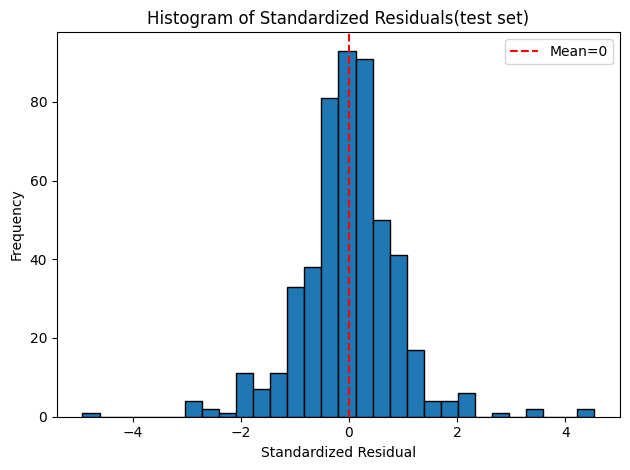

In [77]:

# Histogram of Standardized Residuals
plt.hist(std_resid_series, bins=30, edgecolor='black')
plt.title('Histogram of Standardized Residuals(test set)')
plt.xlabel('Standardized Residual')
plt.ylabel('Frequency')
plt.axvline(0, color='r', linestyle='--', label='Mean=0')
plt.legend()

plt.tight_layout()
plt.show()



In [78]:
#Formatting time stamps-communication(convert predictions to a formart that can be used for  web application)
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0]+pd.DateOffset(days=1)

# Create date range
prediction_dates = pd.bdate_range(start=start,periods=prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index =[d.isoformat() for d in prediction_dates]
print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1      h.2       h.3       h.4       h.5
date                                                       
2025-10-31  1.711038  1.72702  1.742855  1.758547  1.774101
prediction_index type: <class 'list'>
prediction_index len: 5


['2025-11-03T00:00:00', '2025-11-04T00:00:00', '2025-11-05T00:00:00']

In [80]:
def clean_prediction(prediction):
    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
       # Calculate forecast start date
    start = prediction.index[0]+pd.DateOffset(days=1)
    
    # Create date range
    prediction_dates = pd.bdate_range(start=start,periods=prediction.shape[1])
    
    # Create prediction index labels, ISO 8601 format
    prediction_index =[d.isoformat() for d in prediction_dates]
    # Extract predictions from DataFrame, get square root
    data=prediction.values.flatten()**0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted=pd.Series(data,index=prediction_index)

    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [81]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2025-11-03T00:00:00': 1.7110383148170178,
 '2025-11-04T00:00:00': 1.7270198434652413,
 '2025-11-05T00:00:00': 1.7428548339633965,
 '2025-11-06T00:00:00': 1.758547244862212,
 '2025-11-07T00:00:00': 1.7741008596332402,
 '2025-11-10T00:00:00': 1.7895192973215897,
 '2025-11-11T00:00:00': 1.8048060223795075,
 '2025-11-12T00:00:00': 1.8199643537565107,
 '2025-11-13T00:00:00': 1.834997473313628,
 '2025-11-14T00:00:00': 1.8499084336221827}